In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from DL_models import UNet  
from DL_models import CNN
from loss_function import CombinedLoss
from train_test import train_model
from train_test import evaluate_model_sr
from visualization import plot_predictions_vs_targets
from visualization import plot_mean_power_spectrum
from visualization import plot_train_val_losses
from visualization import plot_mean_esr
from dataloading import prepare_dataloaders
from qualitative_eval import mse, r2_score, pearson_corr

In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

# importlib.reload(preprocessing)
# from preprocessing import preprocess_data

# from model_eval_plotting import evaluate_model
# from model_eval_plotting import plot_predictions_vs_targets

# from CNN_setup import SimpleCNN
# from CNN_setup import TensorDataset

# from gcm_filtering import filter_inputs_dataset
# from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


# Data Pre-processing

In [3]:
ds_HR = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_20Yrs.zarr", engine="zarr", chunks={}
) 
ds_HR

<xarray.Dataset> Size: 342GB
Dimensions:       (yt_ocean: 2700, xt_ocean: 3600, time: 731)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time          (time) object 6kB 0181-01-01 12:00:00 ... 0200-12-27 12:00:00
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [4]:
ds_LR = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_LR_southAtlantic_every10TimeSteps_20Yrs.zarr", engine="zarr", chunks={}
) 
ds_LR

<xarray.Dataset> Size: 171GB
Dimensions:       (time: 731, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 6kB 0181-01-01 12:00:00 ... 0200-12-27 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [5]:
# Select region of interest
ds_HR_reg = ds_HR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_LR_reg = ds_LR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))

In [6]:
train_loader, val_loader, test_loader, HR_test, LR_test = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='u_relative', batch_size=32, normalization_type='normalization')

Training set size: 511
Validation set size: 109
Testing set size: 111


# ML Model Training

In [7]:
# Set the values you want
in_channels = 1  # num of input channels
image_height = LR_test.shape[1]
image_width = LR_test.shape[2]
output_channels = 1 

# Instantiate the model with the parameters
model = CNN(in_channels, image_height, image_width, output_channels)
model

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=59200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=60000, bias=True)
)

In [22]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_trial1.pth',
            n_epochs=10) # n_epochs=2000)

Trainable Parameters: 15341024
Epoch 1, Train Loss: 2.418e-01, Val Loss: 2.179e-01, Epoch Time: 9.15s
Model saved at epoch 1
Epoch 2, Train Loss: 1.758e-01, Val Loss: 1.347e-01, Epoch Time: 9.16s
Model saved at epoch 2
Epoch 3, Train Loss: 9.811e-02, Val Loss: 6.876e-02, Epoch Time: 9.09s
Model saved at epoch 3
Epoch 4, Train Loss: 4.757e-02, Val Loss: 3.299e-02, Epoch Time: 8.99s
Model saved at epoch 4
Epoch 5, Train Loss: 2.363e-02, Val Loss: 1.852e-02, Epoch Time: 9.08s
Model saved at epoch 5
Epoch 6, Train Loss: 1.440e-02, Val Loss: 1.353e-02, Epoch Time: 9.09s
Model saved at epoch 6
Epoch 7, Train Loss: 1.142e-02, Val Loss: 1.207e-02, Epoch Time: 9.27s
Model saved at epoch 7
Epoch 8, Train Loss: 1.058e-02, Val Loss: 1.170e-02, Epoch Time: 9.00s
Model saved at epoch 8
Epoch 9, Train Loss: 1.039e-02, Val Loss: 1.158e-02, Epoch Time: 9.07s
Model saved at epoch 9
Epoch 10, Train Loss: 1.032e-02, Val Loss: 1.158e-02, Epoch Time: 8.90s
Model saved at epoch 10
Training complete


In [8]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_trial1.pth')
sr_pred

Loaded model parameters from ./model_trial1.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[0.37889415, 0.38227984, 0.38001883, ..., 0.36306325,
         0.3609261 , 0.36046708],
        [0.38250005, 0.3787461 , 0.38017172, ..., 0.36229783,
         0.36026317, 0.3606939 ],
        [0.37985846, 0.38207874, 0.38271743, ..., 0.35878488,
         0.36459646, 0.3619995 ],
        ...,
        [0.5415793 , 0.539635  , 0.5364978 , ..., 0.53650075,
         0.5346085 , 0.53509593],
        [0.53854746, 0.5385662 , 0.53934956, ..., 0.5352013 ,
         0.5342198 , 0.53156203],
        [0.5372015 , 0.5369181 , 0.53711   , ..., 0.5319823 ,
         0.53592986, 0.5344354 ]],

       [[0.3594208 , 0.36306405, 0.3640042 , ..., 0.34294704,
         0.34144598, 0.3440161 ],
        [0.364936  , 0.36677745, 0.36258188, ..., 0.34368074,
         0.34429237, 0.34493458],
        [0.3629781 , 0.36830664, 0.3665337 , ..., 0.3457891 ,
         0.34385678, 0.34699482],
...
        [0.4622063 , 0.46128422, 0.47428253, ..., 0.45647475,
         0.45787653, 0.45450366],
        [0.46604022, 0.463605  , 0.46047464, ..., 0.46161446,
         0.46267864, 0.47177148],
        [0.45378733, 0.469049  , 0.46789825, ..., 0.46729162,
         0.45123056, 0.47360876]],

       [[0.4084524 , 0.41243738, 0.40007198, ..., 0.39342612,
         0.386576  , 0.38780287],
        [0.4037868 , 0.3969866 , 0.40363222, ..., 0.39060047,
         0.3837228 , 0.38728055],
        [0.4040913 , 0.40240327, 0.40749088, ..., 0.3770163 ,
         0.39224097, 0.3830359 ],
        ...,
        [0.5823896 , 0.5784811 , 0.56874645, ..., 0.5771356 ,
         0.5739179 , 0.5762728 ],
        [0.57562363, 0.57606375, 0.5798602 , ..., 0.5713265 ,
         0.57109743, 0.56296337],
        [0.5798915 , 0.5720826 , 0.5727395 , ..., 0.56465614,
         0.57906973, 0.56484747]]], shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0185-11-06 12:00:00 ... 0192-12-29 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

# Visualizations

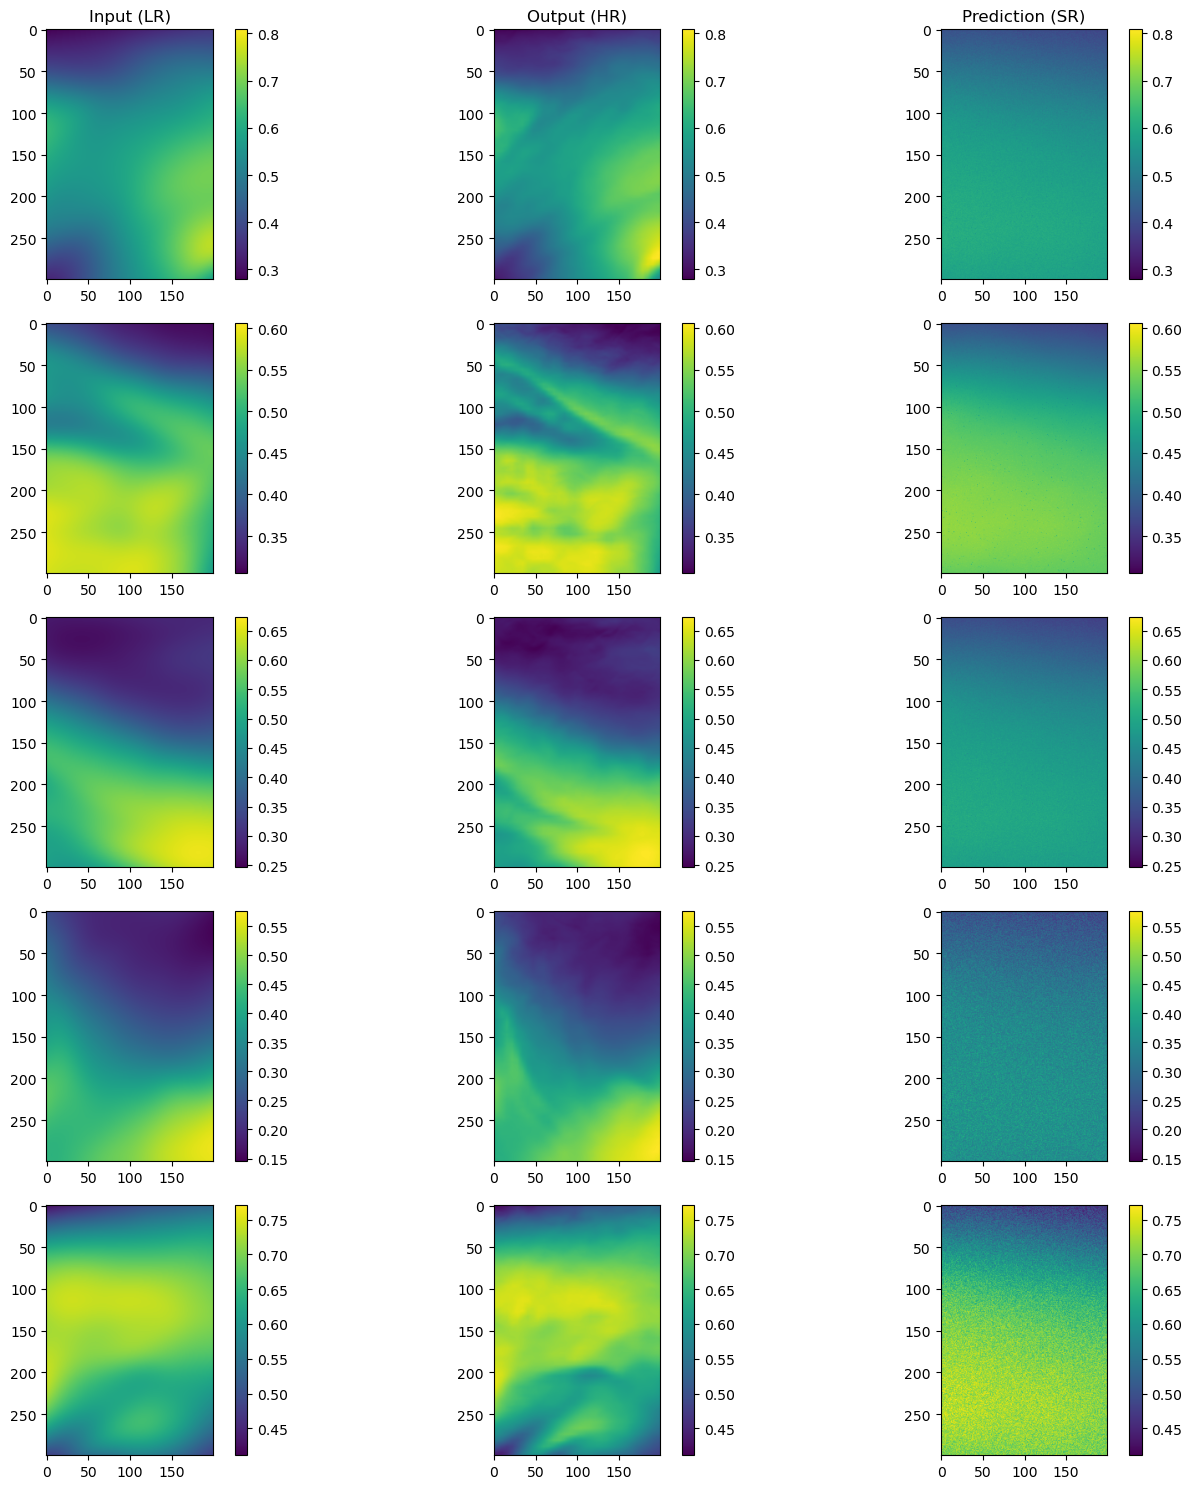

In [24]:
plot_predictions_vs_targets(LR_test, HR_test, sr_pred, num_samples=5, cmap='viridis')

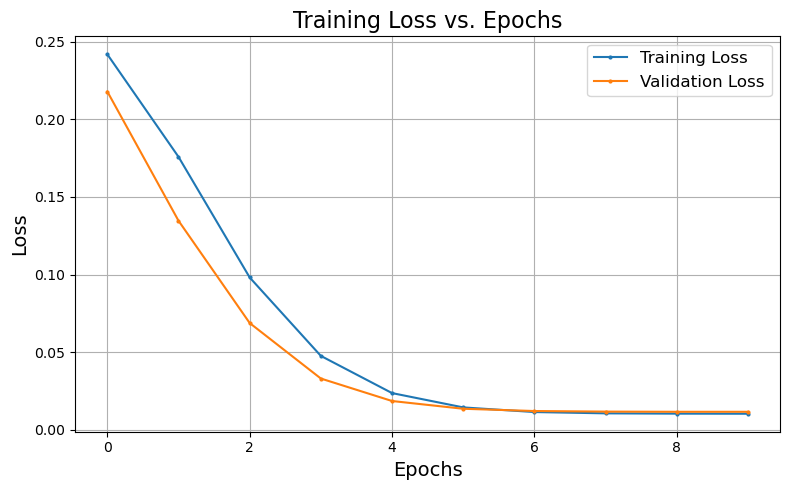

In [26]:
plot_train_val_losses(train_losses, val_losses)

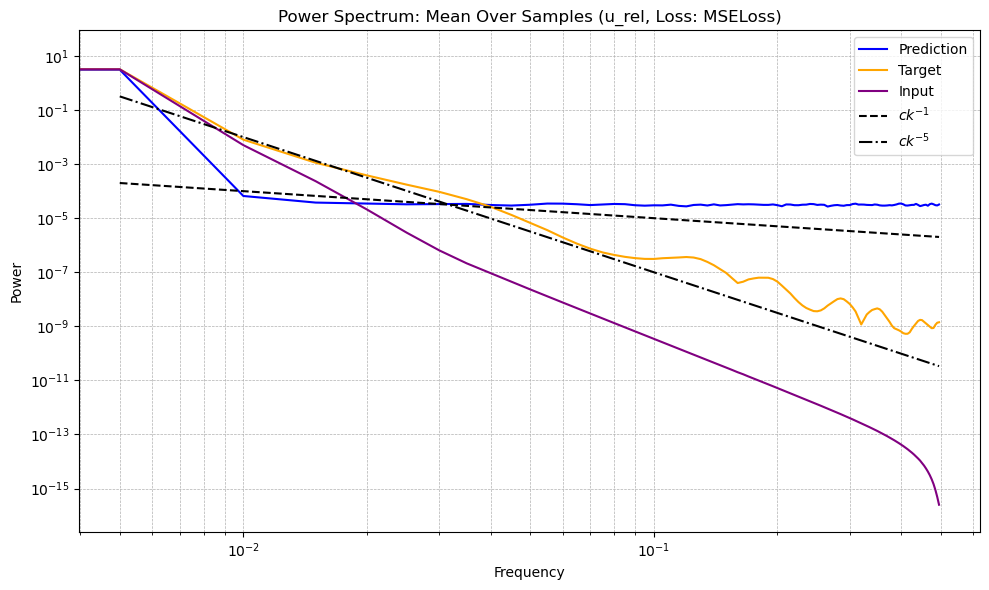

In [10]:
plot_mean_power_spectrum(
    sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="MSELoss", alpha_label="", figsize=(10, 6),
    c1=10**-6, c5=10**-12, show_slopes=True)

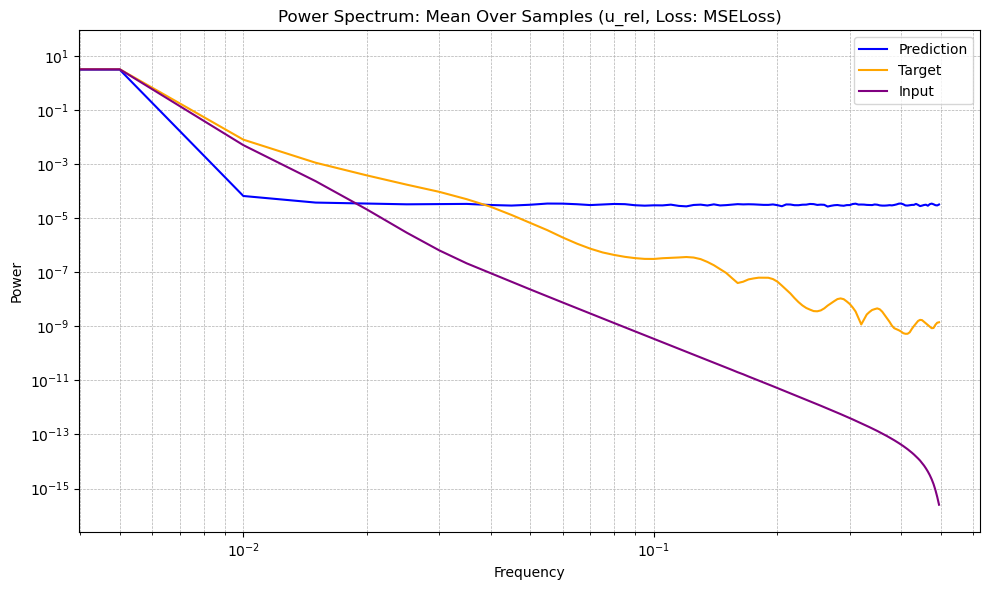

In [11]:
plot_mean_power_spectrum(
    sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="MSELoss", alpha_label="", figsize=(10, 6))

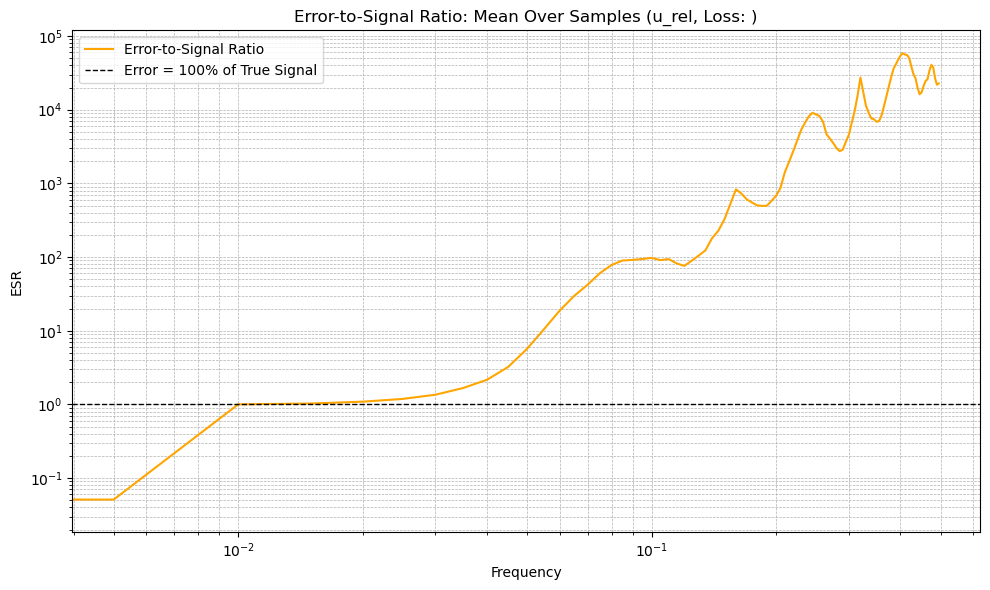

In [12]:
plot_mean_esr(sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="", alpha_label="", figsize=(10, 6))

# Quantitative Metrics

In [15]:
mse(HR_test, sr_pred)

0.010861282236874104

In [13]:
pearson_corr(HR_test, sr_pred)

0.6317108508346513

In [14]:
r2_score(HR_test, sr_pred)

0.39472347497940063